In [310]:
import os
import numpy as np
from sklearn.cluster import KMeans,HDBSCAN
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

import multiprocessing as mp
import matplotlib.pyplot as plt
from pprint import pprint
from shutil import copyfile

import warnings


In [311]:
protein_pdb = "/mnt/sdc/lanwei/MC1R/MC1R.pdb"
peptide_pdb_dir = '/mnt/sdc/lanwei/MC1R/HPEP/v3/'
point_plot = f'{peptide_pdb_dir}/cluster_point_plot.png'
cluster_result = f'{peptide_pdb_dir}/cluster_result.txt'

In [312]:
protein_coords = []
with open(protein_pdb) as f:
    for line in f:
        if line.startswith('ATOM'):
            x = float(line[30:38]) 
            y = float(line[38:46])
            z = float(line[46:54]) 
            protein_coords.append([x, y, z])
print(len(protein_coords))

2189


In [313]:
peptide_coords = []
peptide_names = []
for pdb in os.listdir(peptide_pdb_dir):
    if pdb.endswith('.pdb'):
        coords = []
        with open(os.path.join(peptide_pdb_dir, pdb)) as f:
            for line in f:
                if line.startswith('ATOM'):
                    x = float(line[30:38])
                    y = float(line[38:46]) 
                    z = float(line[46:54])
                    coords.append([x, y, z])
        peptide_coords.append(coords)
        peptide_names.append(pdb.split('.')[0])
print(len(peptide_coords))

110


In [314]:
def calc_contacts(peptide_idx, peptide_coords, protein_coords):
    dists = [0] * len(protein_coords)
    for p_idx, p_coord in enumerate(protein_coords):
        contact = 0
        for pe_coord in peptide_coords[peptide_idx]:
            dist = np.linalg.norm(np.array(p_coord) - np.array(pe_coord))  
            if dist < 7:
                contact += 1
                #break
        
        dists[p_idx] = contact
        
    return dists


contact_matrices = []

with mp.Pool() as pool:
    results = [pool.apply_async(calc_contacts, args=(i, peptide_coords, protein_coords)) 
            for i in range(len(peptide_coords))]
    contact_matrices = [r.get() for r in results]
print(len(contact_matrices))


110


In [315]:
contact_matrixs = []
for dists in contact_matrices:
    contact_matrixs.append(dists)
contact_matrixs = np.array(contact_matrixs)

def cluster_score(estimator, X, y):
    labels = estimator.fit_predict(X)
    if len(np.unique(labels)) <= 1:
        return 0
  
    return silhouette_score(X, labels)

In [ ]:
scores = {}
for clusters_number in range(2, 15):

        km = KMeans(n_clusters = clusters_number,
                    #cluster_selection_epsilon = eps,
                    n_init=10
                     ) 
        labels = km.fit_predict(contact_matrixs)
        score = cluster_score(km ,contact_matrixs,  labels)
        scores[km] = score
        print(f'{km} this params score is {score}')


plt.plot(list(range(len(scores))), scores.values())
plt.xlabel('Trials') 
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Trials')
plt.show

print(max(scores, key=scores.get))


In [ ]:
km = KMeans(n_clusters=2, 
            n_init=10
            ) 
labels = km.fit_predict(contact_matrixs)
score = cluster_score(km ,contact_matrixs,  labels)
scores[km] = score
print(f'{km} this params score is {score}')

HDBSCAN(min_cluster_size=2) this params score is 0.4228171410562349
HDBSCAN(min_cluster_size=3) this params score is 0.4228171410562349
HDBSCAN(min_cluster_size=4) this params score is 0.4228171410562349
HDBSCAN() this params score is 0.4228171410562349
HDBSCAN(min_cluster_size=6) this params score is 0.4228171410562349
HDBSCAN(min_cluster_size=7) this params score is 0.4228171410562349
HDBSCAN(min_cluster_size=8) this params score is 0.4228171410562349
HDBSCAN(min_cluster_size=9) this params score is 0.4228171410562349
HDBSCAN(min_cluster_size=10) this params score is 0.3988339114179284
HDBSCAN(min_cluster_size=11) this params score is 0.3988339114179284
HDBSCAN(min_cluster_size=12) this params score is 0.3988339114179284
HDBSCAN(min_cluster_size=13) this params score is 0.3988339114179284
HDBSCAN(min_cluster_size=14) this params score is 0.3988339114179284
HDBSCAN(min_cluster_size=2)


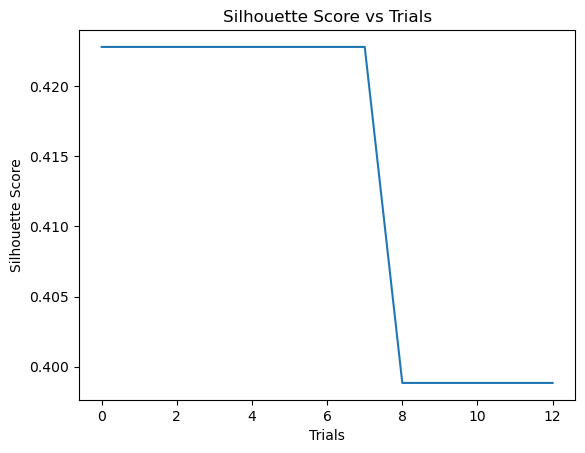

In [317]:

scores = {}
for clusters_number in range(2, 15):
    #for eps in [x*0.1 for x in range(1,20,2)]:

        km = HDBSCAN(min_cluster_size = clusters_number,
                     #cluster_selection_epsilon = eps
                     ) 
        labels = km.fit_predict(contact_matrixs)
        score = cluster_score(km ,contact_matrixs,  labels)
        scores[km] = score
        print(f'{km} this params score is {score}')


plt.plot(list(range(len(scores))), scores.values())
plt.xlabel('Trials') 
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Trials')
plt.show

print(max(scores, key=scores.get))



In [318]:
km = HDBSCAN(min_cluster_size=2, 
            #cluster_selection_epsilon=1.5
            ) 
labels = km.fit_predict(contact_matrixs)
score = cluster_score(km ,contact_matrixs,  labels)
scores[km] = score
print(f'{km} this params score is {score}')

HDBSCAN(min_cluster_size=2) this params score is 0.4228171410562349


In [319]:
cluster_keys = {}
for label in set(labels):
    cluster_keys[label] = []
for i, label in enumerate(labels):
    cluster_keys[label].append(peptide_names[i])
final_label = []
for label in sorted(cluster_keys):
        print(f'Cluster {label}:{cluster_keys[label]}\n {len(cluster_keys[label])}')
f.close()  

Cluster 0:['TRGRKCFRRK', 'TRGRKCSRRK', 'FRWGKPVFKK', 'CRGRKCCRRK', 'FRWGKCVGKK', 'IRGRKCCRRK', 'FRWGKPVLKK', 'KKRRVVKVY', 'KRWGKPVGKK', 'FRWPKPVGKK', 'CRWGKPVGKK', 'FRWKKPVGKK', 'TRGRKCNRRK', 'FRWYKPVGKK', 'FRWGKKVGKK', 'FRWGKPVQKK', 'WRWGKPVGKK', 'TRGRKCPRRK', 'FRWGKRVGKK', 'FRWGKPTGKK', 'RRGRKCCRRK', 'FRWGKWVGKK', 'FRWGKPRGKK', 'FRWGKPNGKK', 'KKRRKVKVY', 'FRWGKPSGKK', 'KKRRCVKVY', 'TRGRKCWRRK', 'SRGRKCCRRK', 'VRGRKCCRRK', 'FRWSKPVGKK', 'TRGRKCGRRK', 'ARGRKCCRRK', 'FRWGKPIGKK', 'FRWGKPQGKK', 'FRWNKPVGKK', 'KYYCRVRGKR', 'KRGRKCCRRK', 'KYYCRVRGCR', 'FRGRKCCRRK', 'FRWGKPFGKK', 'KKRRSVKVY', 'FRWGKPAGKK', 'KKRRQVKVY', 'TRGRKCCRRK', 'TRGRKCYRRK', 'KYYCRVRGHR', 'KYYCRVRGPR', 'KYYCRVRGRR', 'FRWGKPGGKK', 'GRGRKCCRRK', 'FRWGKIVGKK', 'KYYCRVRGWR', 'TRGRKCRRRK', 'FRWGKPVRKK', 'TRGRKCLRRK', 'NRGRKCCRRK', 'KYYCRVRGYR', 'FRWGKPHGKK', 'KYYRRVRGGR', 'FRWCKPVGKK', 'TRGRKCQRRK', 'TRGRKCVRRK', 'TRGRKCHRRK', 'TRGRKCERRK', 'TRGRKCMRRK', 'KKRRPVKVY', 'TRGRKCKRRK', 'KKRRWVKVY', 'QRGRKCCRRK', 'ERGRKCCRRK', 'F

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


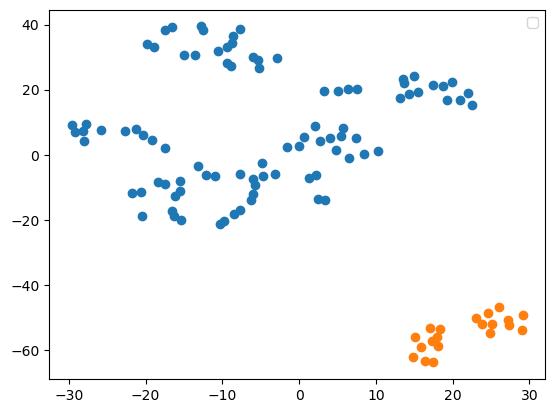

In [320]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(contact_matrixs)

# 2D散点图
fig, ax = plt.subplots()

for i in range(clusters_number):
    ax.scatter(X_tsne[labels==i, 0], 
            X_tsne[labels==i, 1], 
            )
ax.legend()
plt.show()

In [326]:

cluster_labels_pdb = []
for cluster_labels_keys in cluster_keys.keys():
    cluster_labels_pdb.append(cluster_keys[cluster_labels_keys])

a = 0

for cluster_label_pdb in cluster_labels_pdb:
    print(cluster_label_pdb)
    i = 0
    a = a + 1
  # 定义输出pdb文件名
    out_file = os.path.join(peptide_pdb_dir, f'{a}.pdb' )
    
    for pdb in cluster_label_pdb:
       
        pdb_file = os.path.join(peptide_pdb_dir, pdb + '.pdb')
        with open(out_file, 'a') as f_out:
            with open(pdb_file) as f_in:
              i = i + 1
              f_out.write(f'\nMODEL {i}\n')
              
              # 过滤掉MODEL/END/ENDMDL行
              lines = [line for line in f_in if 'MODEL' not in line 
                        and 'END' not in line and 'ENDMDL' not in line]  

              f_out.write(''.join(lines))

              f_out.write(f_in.read())
              f_out.write('END\n')
              f_out.write('ENDMDL\n\n')


['TRGRKCFRRK', 'TRGRKCSRRK', 'FRWGKPVFKK', 'CRGRKCCRRK', 'FRWGKCVGKK', 'IRGRKCCRRK', 'FRWGKPVLKK', 'KKRRVVKVY', 'KRWGKPVGKK', 'FRWPKPVGKK', 'CRWGKPVGKK', 'FRWKKPVGKK', 'TRGRKCNRRK', 'FRWYKPVGKK', 'FRWGKKVGKK', 'FRWGKPVQKK', 'WRWGKPVGKK', 'TRGRKCPRRK', 'FRWGKRVGKK', 'FRWGKPTGKK', 'RRGRKCCRRK', 'FRWGKWVGKK', 'FRWGKPRGKK', 'FRWGKPNGKK', 'KKRRKVKVY', 'FRWGKPSGKK', 'KKRRCVKVY', 'TRGRKCWRRK', 'SRGRKCCRRK', 'VRGRKCCRRK', 'FRWSKPVGKK', 'TRGRKCGRRK', 'ARGRKCCRRK', 'FRWGKPIGKK', 'FRWGKPQGKK', 'FRWNKPVGKK', 'KYYCRVRGKR', 'KRGRKCCRRK', 'KYYCRVRGCR', 'FRGRKCCRRK', 'FRWGKPFGKK', 'KKRRSVKVY', 'FRWGKPAGKK', 'KKRRQVKVY', 'TRGRKCCRRK', 'TRGRKCYRRK', 'KYYCRVRGHR', 'KYYCRVRGPR', 'KYYCRVRGRR', 'FRWGKPGGKK', 'GRGRKCCRRK', 'FRWGKIVGKK', 'KYYCRVRGWR', 'TRGRKCRRRK', 'FRWGKPVRKK', 'TRGRKCLRRK', 'NRGRKCCRRK', 'KYYCRVRGYR', 'FRWGKPHGKK', 'KYYRRVRGGR', 'FRWCKPVGKK', 'TRGRKCQRRK', 'TRGRKCVRRK', 'TRGRKCHRRK', 'TRGRKCERRK', 'TRGRKCMRRK', 'KKRRPVKVY', 'TRGRKCKRRK', 'KKRRWVKVY', 'QRGRKCCRRK', 'ERGRKCCRRK', 'FRWGKGVGKK'

In [325]:
# 获取第一个键对应的值
first_value = cluster_keys[list(cluster_keys.keys())[0]]

# 获取其他键对应的值(除了最多的那个)并合并到 result 列表中
result = [v for k, v in cluster_keys.items() if k != first_key]

# 将所有值合并为一个列表
result = [item for sublist in result for item in sublist]

print(first_value)
print(len(first_value))


['TRGRKCFRRK', 'TRGRKCSRRK', 'FRWGKPVFKK', 'CRGRKCCRRK', 'FRWGKCVGKK', 'IRGRKCCRRK', 'FRWGKPVLKK', 'KKRRVVKVY', 'KRWGKPVGKK', 'FRWPKPVGKK', 'CRWGKPVGKK', 'FRWKKPVGKK', 'TRGRKCNRRK', 'FRWYKPVGKK', 'FRWGKKVGKK', 'FRWGKPVQKK', 'WRWGKPVGKK', 'TRGRKCPRRK', 'FRWGKRVGKK', 'FRWGKPTGKK', 'RRGRKCCRRK', 'FRWGKWVGKK', 'FRWGKPRGKK', 'FRWGKPNGKK', 'KKRRKVKVY', 'FRWGKPSGKK', 'KKRRCVKVY', 'TRGRKCWRRK', 'SRGRKCCRRK', 'VRGRKCCRRK', 'FRWSKPVGKK', 'TRGRKCGRRK', 'ARGRKCCRRK', 'FRWGKPIGKK', 'FRWGKPQGKK', 'FRWNKPVGKK', 'KYYCRVRGKR', 'KRGRKCCRRK', 'KYYCRVRGCR', 'FRGRKCCRRK', 'FRWGKPFGKK', 'KKRRSVKVY', 'FRWGKPAGKK', 'KKRRQVKVY', 'TRGRKCCRRK', 'TRGRKCYRRK', 'KYYCRVRGHR', 'KYYCRVRGPR', 'KYYCRVRGRR', 'FRWGKPGGKK', 'GRGRKCCRRK', 'FRWGKIVGKK', 'KYYCRVRGWR', 'TRGRKCRRRK', 'FRWGKPVRKK', 'TRGRKCLRRK', 'NRGRKCCRRK', 'KYYCRVRGYR', 'FRWGKPHGKK', 'KYYRRVRGGR', 'FRWCKPVGKK', 'TRGRKCQRRK', 'TRGRKCVRRK', 'TRGRKCHRRK', 'TRGRKCERRK', 'TRGRKCMRRK', 'KKRRPVKVY', 'TRGRKCKRRK', 'KKRRWVKVY', 'QRGRKCCRRK', 'ERGRKCCRRK', 'FRWGKGVGKK'

In [345]:

another_peptide_coords = []
another_peptide_names = []
for pdb in os.listdir(new_dir):
    if pdb.endswith('.pdb'):
        coords = []
        with open(os.path.join(new_dir, pdb)) as f:
            for line in f:
                if line.startswith('ATOM'):
                    x = float(line[30:38])
                    y = float(line[38:46]) 
                    z = float(line[46:54])
                    coords.append([x, y, z])
        another_peptide_coords.append(coords)
        another_peptide_names.append(pdb.split('.')[0])
print(len(another_peptide_coords))


90


In [346]:
def calc_contacts(peptide_idx, peptide_coords, protein_coords):
    dists = [0] * len(protein_coords)
    for p_idx, p_coord in enumerate(protein_coords):
        contact = 0
        for pe_coord in peptide_coords[peptide_idx]:
            dist = np.linalg.norm(np.array(p_coord) - np.array(pe_coord))  
            if dist < 7:
                contact += 1
                #break
        
        dists[p_idx] = contact
        
    return dists

another_contact_matrices = []

with mp.Pool() as pool:
    results = [pool.apply_async(calc_contacts, args=(i, another_peptide_coords, protein_coords)) 
            for i in range(len(another_peptide_coords))]
    another_contact_matrices = [r.get() for r in results]
print(len(another_contact_matrices))

90


In [347]:
another_contact_matrixs = []
for dists in another_contact_matrices:
    another_contact_matrixs.append(dists)
another_contact_matrixs = np.array(another_contact_matrixs)
print(len(another_contact_matrixs))

90


HDBSCAN(min_cluster_size=2) this params score is 0.03641182603021069
HDBSCAN(min_cluster_size=3) this params score is 0.060520331340626066
HDBSCAN(min_cluster_size=4) this params score is 0.029077882687332628
HDBSCAN() this params score is 0.02097636849854689
HDBSCAN(min_cluster_size=6) this params score is 0.013597043296271708
HDBSCAN(min_cluster_size=7) this params score is -0.00507771664402636
HDBSCAN(min_cluster_size=8) this params score is -0.04164319187535643
HDBSCAN(min_cluster_size=9) this params score is -0.04306700635967764
HDBSCAN(min_cluster_size=10) this params score is 0
HDBSCAN(min_cluster_size=11) this params score is 0
HDBSCAN(min_cluster_size=12) this params score is 0
HDBSCAN(min_cluster_size=13) this params score is 0
HDBSCAN(min_cluster_size=14) this params score is 0
HDBSCAN(min_cluster_size=3)


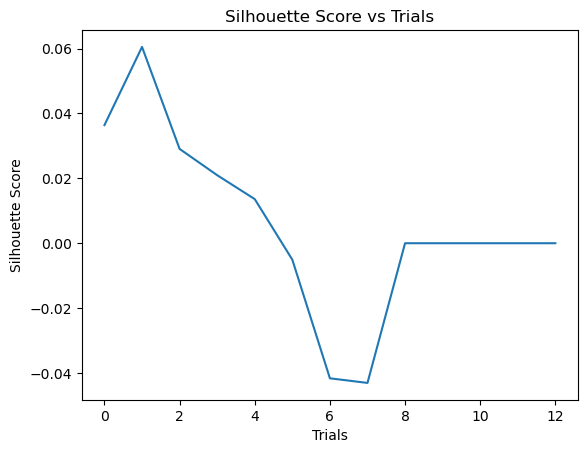

In [348]:

scores = {}
for clusters_number in range(2, 15):
    #for eps in [x*0.1 for x in range(1,20,2)]:

        km = HDBSCAN(min_cluster_size = clusters_number,
                     #cluster_selection_epsilon = eps
                     ) 
        labels = km.fit_predict(another_contact_matrixs)
        score = cluster_score(km ,another_contact_matrixs,  labels)
        scores[km] = score
        print(f'{km} this params score is {score}')


plt.plot(list(range(len(scores))), scores.values())
plt.xlabel('Trials') 
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Trials')
plt.show

print(max(scores, key=scores.get))




In [349]:

km1 =HDBSCAN(min_cluster_size = 2)

labels = km1.fit_predict(another_contact_matrixs)
score = cluster_score(km1 ,another_contact_matrixs,  labels)
scores[km1] = score
print(f'{km1} this params score is {score}\n{len(labels)}')

HDBSCAN(min_cluster_size=2) this params score is 0.03641182603021069
90


Cluster -1:['PRGRKCCRRK', 'FRWGKKVGKK', 'TRGRKCPRRK', 'FRWGKPTGKK', 'RRGRKCCRRK', 'FRWGKWVGKK', 'FRWGKPRGKK', 'FRWGKPSGKK', 'KKRRCVKVY', 'SRGRKCCRRK', 'FRWGKPVWKK', 'ARGRKCCRRK', 'FRWGKPQGKK', 'KYYCRVRGKR', 'FRGRKCCRRK', 'FRWGKPFGKK', 'FRWGKPAGKK', 'TRGRKCCRRK', 'KYYCRVRGHR', 'GRGRKCCRRK', 'KYYCRVRGYR', 'FRWGKPHGKK', 'FRWGKFVGKK', 'RRWGKPVGKK', 'TRGRKCHRRK', 'TRGRKCERRK', 'QRGRKCCRRK', 'ERGRKCCRRK']

Cluster 0:['KKRRTVKVY', 'TRGRKCQRRK']

Cluster 1:['FRWGKPVLKK', 'TRGRKCWRRK']

Cluster 2:['TRGRKCNRRK', 'KYYCRVRGCR', 'NRGRKCCRRK']

Cluster 3:['FRWGKCVGKK', 'KKRRVVKVY', 'FRWYKPVGKK', 'TRGRKCYRRK', 'TRGRKCMRRK', 'KKRRWVKVY', 'FRWGKGVGKK']

Cluster 4:['WRWGKPVGKK', 'TRGRKCGRRK']

Cluster 5:['CRGRKCCRRK', 'TRGRKCRRRK']

Cluster 6:['FRWGKRVGKK', 'FRWGKPVRKK']

Cluster 7:['IRGRKCCRRK', 'TRGRKCLRRK', 'DRGRKCCRRK']

Cluster 8:['KKRRSVKVY', 'FRWGKPGGKK']

Cluster 9:['KKRRDVKVY', 'TRGRKCDRRK']

Cluster 10:['FRWGKPVFKK', 'FRWGKPVQKK']

Cluster 11:['FRWKKPVGKK', 'FRWQKPVGKK', 'FRWTKPVGKK', 'FRWGKIV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


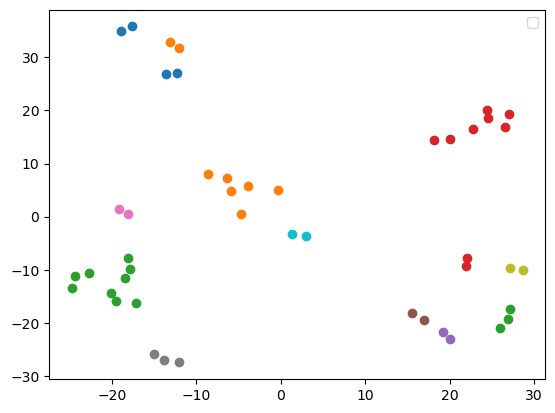

In [350]:
another_cluster_keys = {}
for label in set(labels):
    another_cluster_keys[label] = []
for i, label in enumerate(labels):
    another_cluster_keys[label].append(peptide_names[i])
final_label = []
for label in sorted(another_cluster_keys):
        print(f'Cluster {label}:{another_cluster_keys[label]}\n')
f.close()  

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(another_contact_matrixs)

# 2D散点图
fig, ax = plt.subplots()

for i in range(clusters_number):
    ax.scatter(X_tsne[labels==i, 0], 
            X_tsne[labels==i, 1], 
            )
ax.legend()
plt.show()

In [344]:
another_cluster_labels_pdb = []

# 迭代每个簇标签
for cluster_label_pdb in another_cluster_keys.keys():
    another_cluster_labels_pdb.append(another_cluster_keys[cluster_label_pdb])

a = 0

# 迭代每个簇的PDB文件
for cluster_label_pdb in another_cluster_labels_pdb:
    print(cluster_label_pdb)
    i = 0
    a += 1

    # 定义输出pdb文件名
    out_file = os.path.join(new_dir, f'another_{a}.pdb')  # 更新文件名

    with open(out_file, 'w') as f_out:
        # 迭代每个PDB文件
        for pdb in cluster_label_pdb:
            pdb_file = os.path.join(new_dir, pdb + '.pdb')
            i += 1
            f_out.write(f'\nMODEL {i}\n')

            # 过滤掉MODEL/END/ENDMDL行
            with open(pdb_file) as f_in:
                lines = [line for line in f_in if 'MODEL' not in line
                         and 'END' not in line and 'ENDMDL' not in line]
                
                f_out.write(''.join(lines))

            f_out.write('END\n')
            f_out.write('ENDMDL\n\n')


['KKRRTVKVY', 'TRGRKCQRRK']


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sdc/lanwei/MC1R/HPEP/v3/first_cluster/KKRRTVKVY.pdb'